In [1]:
import os
import json
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
with open(os.path.join("..", "..", "data", 'page_categories.json'), 'r') as f:
    page_categories = json.load(f)

In [3]:
categories_set = set()
count = defaultdict(int)
for page, categories in page_categories.items():
    for category in categories:
        count[category[11:]] += 1
        categories_set.add(category[11:])

In [4]:
for i, c in count.items():
    if c <= 100:
        categories_set.remove(i)

In [5]:
len(categories_set)

1145

In [6]:
main_topics = [
    "Arhitektura",
    "Astronomija",
    "Biologija",
    "Človek",
    "Dogodki",
    "Družba",
    "Film",
    "Filozofija",
    "Fizika",
    "Geografija",
    "Glasba",
    "Izobraževanje",
    "Jezik",
    "Kemija",
    "Kmetijstvo",
    "Književnost",
    "Kultura",
    "Likovna umetnost",
    "Ljudje",
    "Matematika",
    "Narava",
    "Okolje",
    "Politika",
    "Posel",
    "Pravo",
    "Psihologija",
    "Religija",
    "Tehnika",
    "Umetnost",
    "Vojaštvo",
    "Zdravje",
    "Zgodovina",
    "Znanost"
]

In [7]:
for i in main_topics:
    if i in categories_set:
        categories_set.remove(i)

In [8]:
all_categories = main_topics
for i in list(categories_set):
    all_categories.append(i)

In [9]:
category_to_idx_map = defaultdict(int)
idx = 0
for i in all_categories:
    category_to_idx_map[i] = idx
    idx += 1

In [10]:
data_one_hot = np.zeros((len(page_categories), len(all_categories)), dtype=int)

In [11]:
idx_to_id_map = defaultdict(str)
idx = 0
for page, categories in page_categories.items():

    idx_to_id_map[idx] = page

    for category in categories:
        data_one_hot[idx][category_to_idx_map[category[11:]]] = 1

    idx += 1

In [12]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_one_hot)

In [13]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

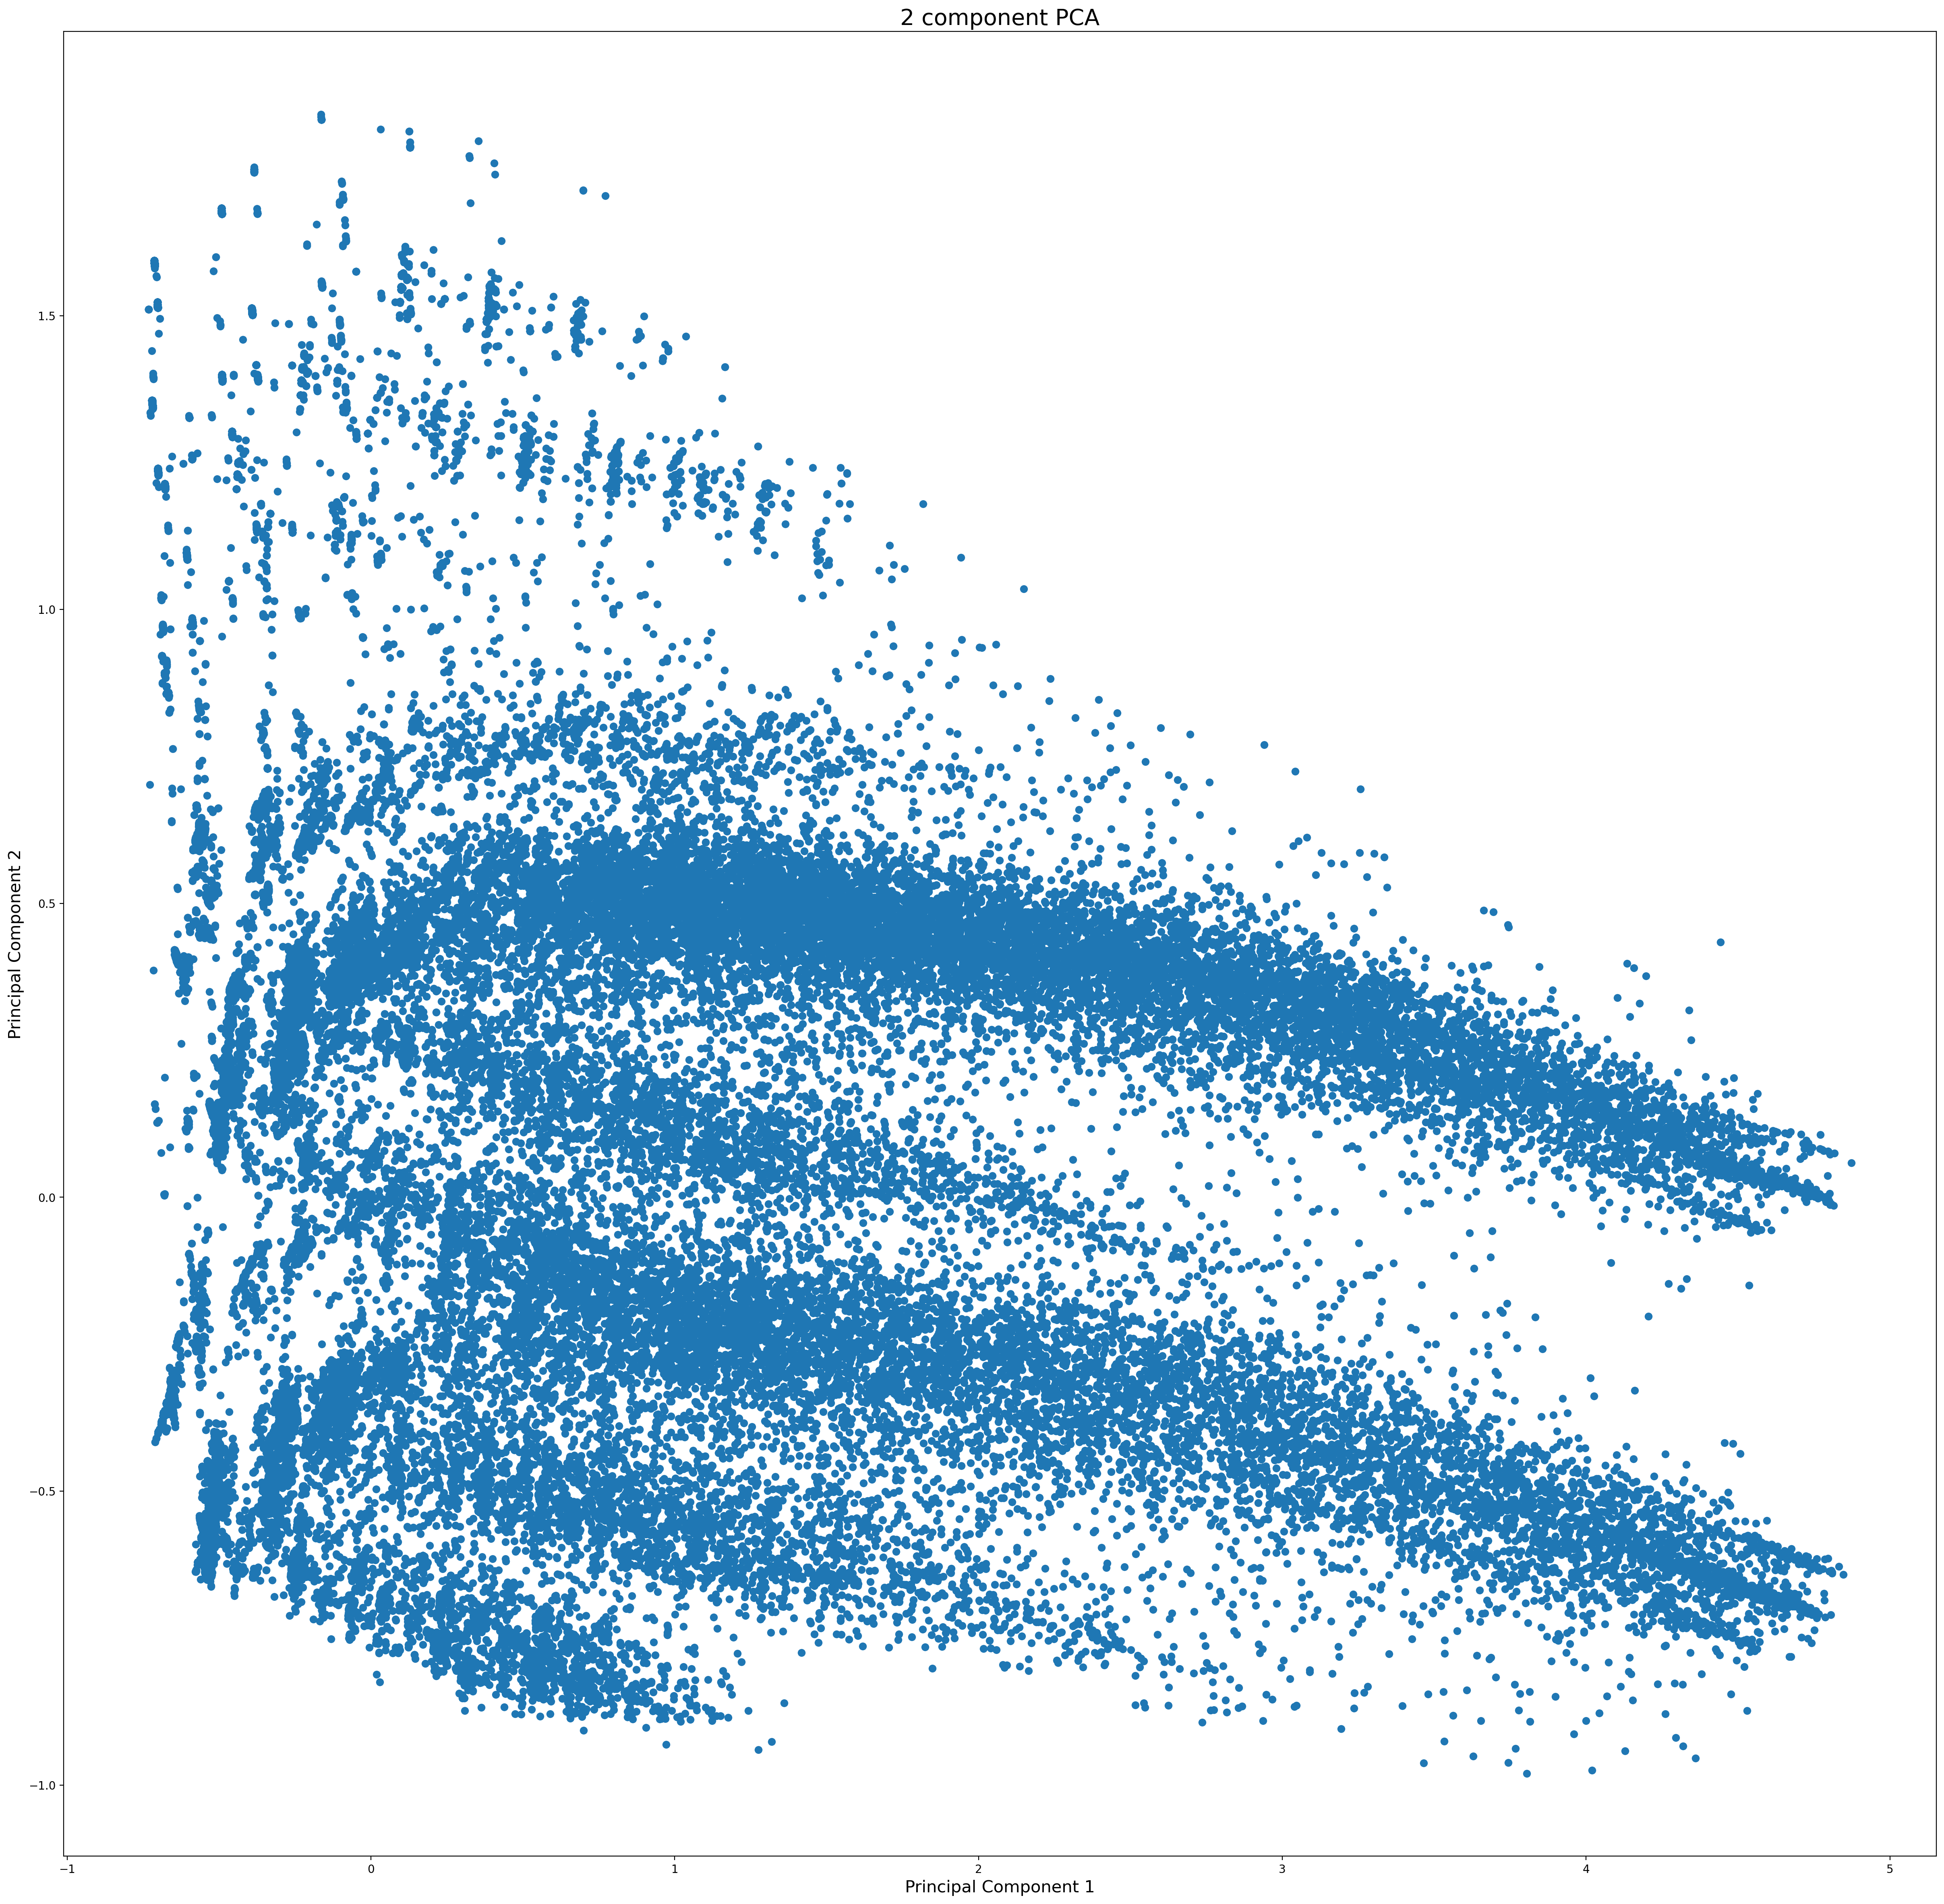

In [14]:

fig = plt.figure(figsize = (30,30), facecolor="white", dpi=200)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])

plt.show()